In [1]:
#! D:\Project\FinalY\venv\Scripts\python.exe
import pandas as pd
import numpy as np



import os
import sys
import wave
import scipy
import scipy.io.wavfile as wav
import scipy.io.wavfile
from scipy.io.wavfile import read

from joblib import Parallel, delayed
import joblib
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.callbacks import ReduceLROnPlateau #Reduce learning rate when a metric has stopped improving
from keras.models import Sequential  
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint #Callback to save the Keras model or model weights at some frequency

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
  

1 . Data Collection

In [2]:
# Paths
raw_audio = "D:/Project/FinalY/TESS Toronto emotional speech set data"  # Main dataset path
augmented_path = "D:/Project/FinalY/TESS_Augmented"  # Folder for processed files

# Ensure augmented path exists
if not os.path.exists(augmented_path):
    os.mkdir(augmented_path)

2 . Data Preprocessing

In [3]:
# Function to trim audio
def trim_audio(path, output_folder):
    # Read the wave file
    samplerate, data = wav.read(path)

    # Filter out low amplitude values
    trimmed_data = data[np.absolute(data) > 50]

    # Save the trimmed audio file
    output_file = os.path.join(output_folder, os.path.basename(path))
    wav.write(output_file, samplerate, trimmed_data)

# Function to check if audio is blank
def blank_audio(path):
    # Set the threshold for maximum amplitude
    THRESHOLD = 0.0001

    # Load the audio file
    audio, sr = librosa.load(path, sr=None)

    # Compute the maximum amplitude
    max_amplitude = max(abs(audio))

    # Check if the maximum amplitude is below the threshold
    return max_amplitude < THRESHOLD

# Process all files in the raw audio directory
raw_audio_directory_list = os.listdir(raw_audio)
for file in raw_audio_directory_list:
    file_path = os.path.join(raw_audio, file)

    try:
        # Skip non-audio files
        if file.endswith('.wav'):
            # Check if the audio is blank
            if blank_audio(file_path):
                continue  # Skip blank audio files
            
            # Trim and save the file
            trim_audio(file_path, augmented_path)
    except:
        pass  # Suppress errors and continue

In [4]:
# Directory list from the raw audio dataset
audio_directory_list = []
for folder in os.listdir(raw_audio):
    folder_path = os.path.join(raw_audio, folder)
    if os.path.isdir(folder_path):
        audio_directory_list.extend([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')])

file_emotion = []
file_path = []

for file in audio_directory_list:
    # Storing file paths
    file_path.append(file)
    
    # Extracting emotion from file name
    parts = file.split('_')[-1]  # Last part contains 'emotion.wav'
    emotion = parts.split('.')[0]  # Remove file extension to isolate the emotion
    if emotion in ['sad', 'angry','fear','disgust']:
        file_emotion.append('negative')
    elif emotion in ['happy','ps']:
        file_emotion.append('positive')
    elif emotion == 'neutral':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# Create DataFrame for emotions and paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
audio_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows
print(audio_df.head())
audio_df.to_csv(os.path.join(augmented_path, "audio_data.csv"), index=False)
print("DataFrame saved at:", os.path.join(augmented_path, "audio_data.csv"))


   Emotions                                               Path
0  negative  D:/Project/FinalY/TESS Toronto emotional speec...
1  negative  D:/Project/FinalY/TESS Toronto emotional speec...
2  negative  D:/Project/FinalY/TESS Toronto emotional speec...
3  negative  D:/Project/FinalY/TESS Toronto emotional speec...
4  negative  D:/Project/FinalY/TESS Toronto emotional speec...
DataFrame saved at: D:/Project/FinalY/TESS_Augmented\audio_data.csv


#

In [5]:
bad_audio_files = []
for path in audio_df.Path:
    try:
        if blank_audio(path):
            bad_audio_files.append(path)
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        bad_audio_files.append(path)  # Treat problematic files as bad audio

audio_df = audio_df[~audio_df.Path.isin(bad_audio_files)]
audio_df.shape


(2800, 2)

3 . Data Visualization

<Axes: xlabel='Emotions', ylabel='count'>

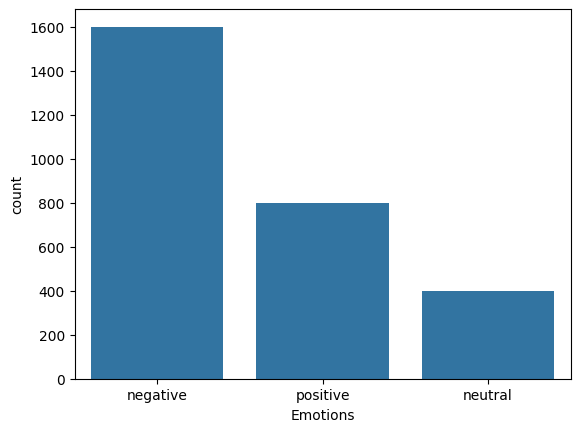

In [6]:
sns.countplot(x ='Emotions', data = audio_df)

In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
   # plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

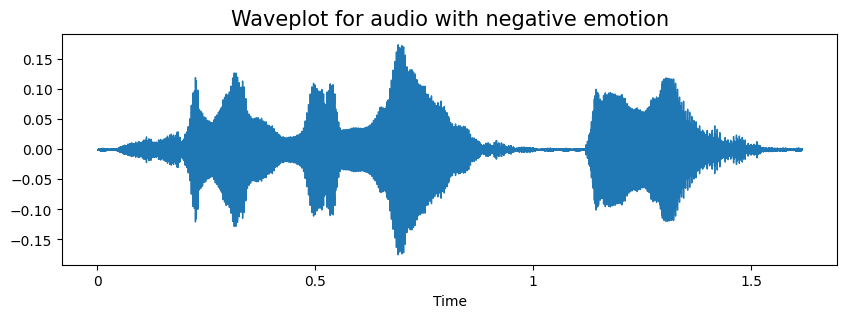

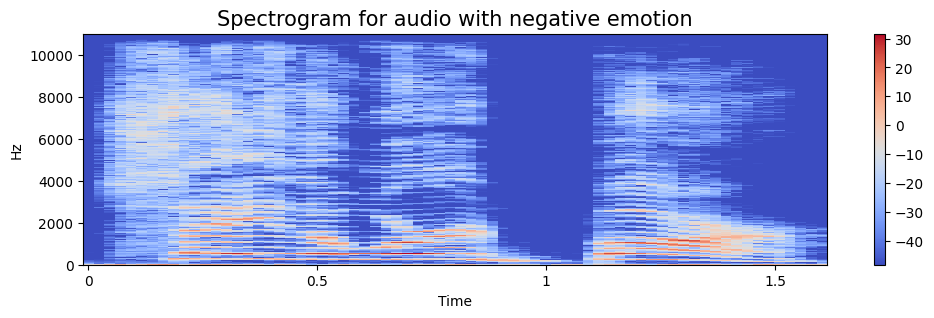

In [8]:
emotion='negative'
path = np.array(audio_df.Path[audio_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

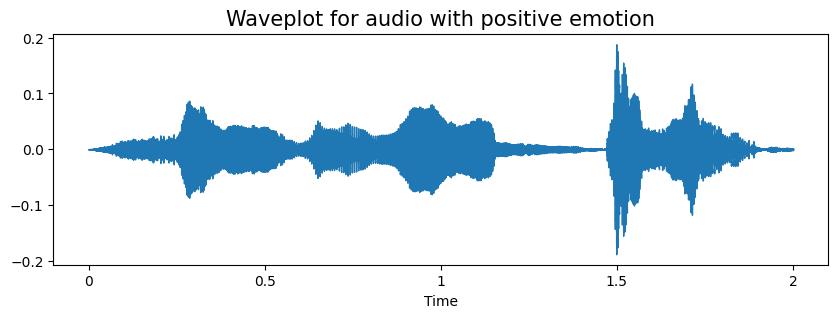

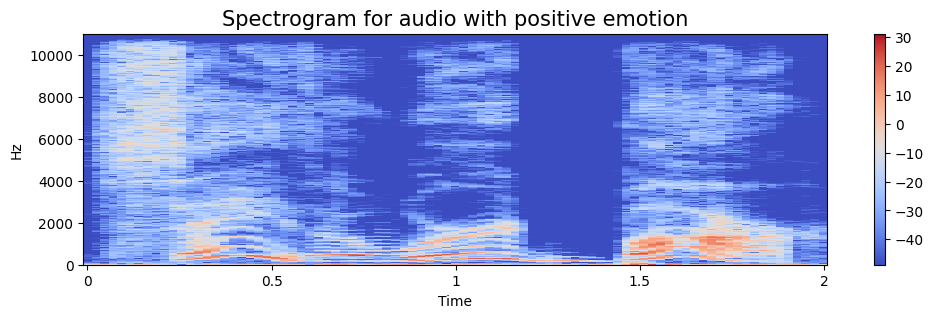

In [9]:
emotion='positive'
path = np.array(audio_df.Path[audio_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

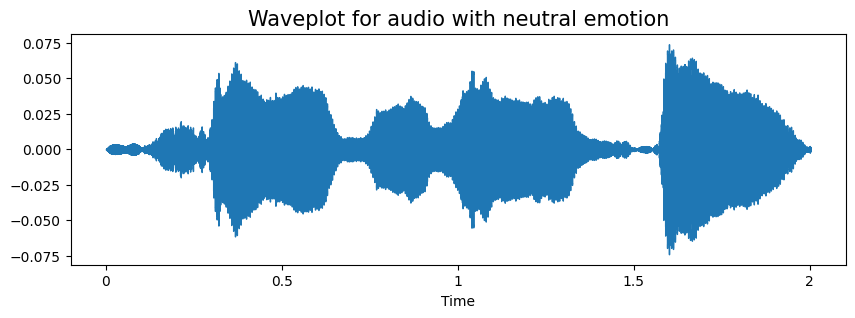

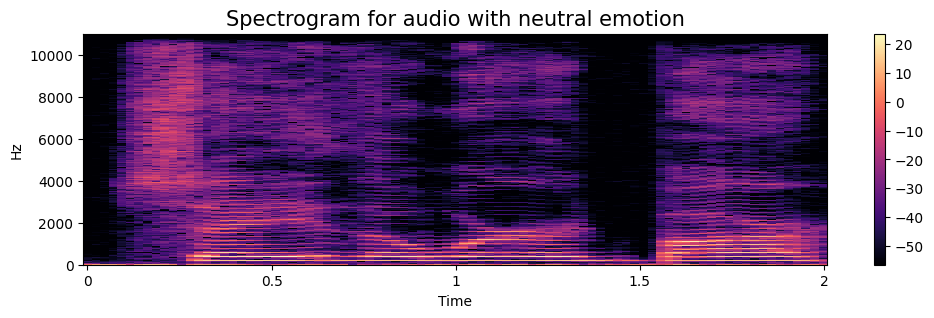

In [10]:
emotion='neutral'
path = np.array(audio_df.Path[audio_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

4 . Feature Extraction

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [12]:
# taking any example and checking for techniques.
path = np.array(audio_df.Path)[100]
data, sample_rate = librosa.load(path)

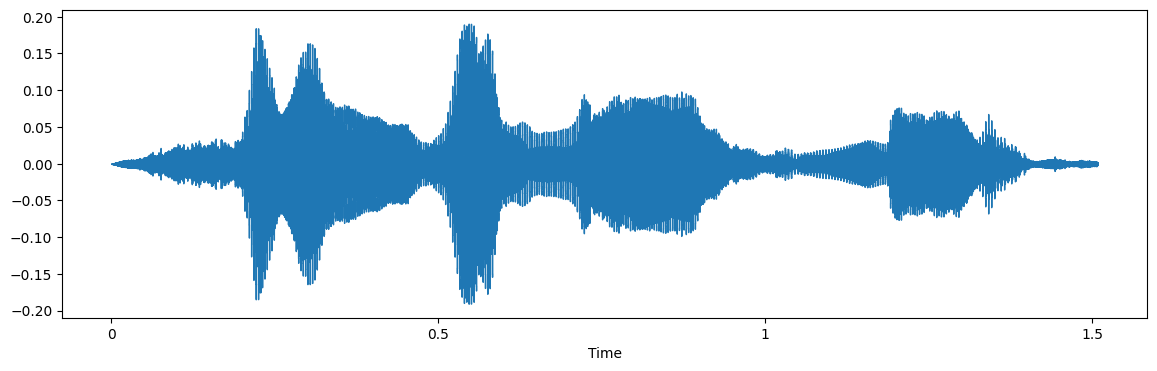

In [13]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

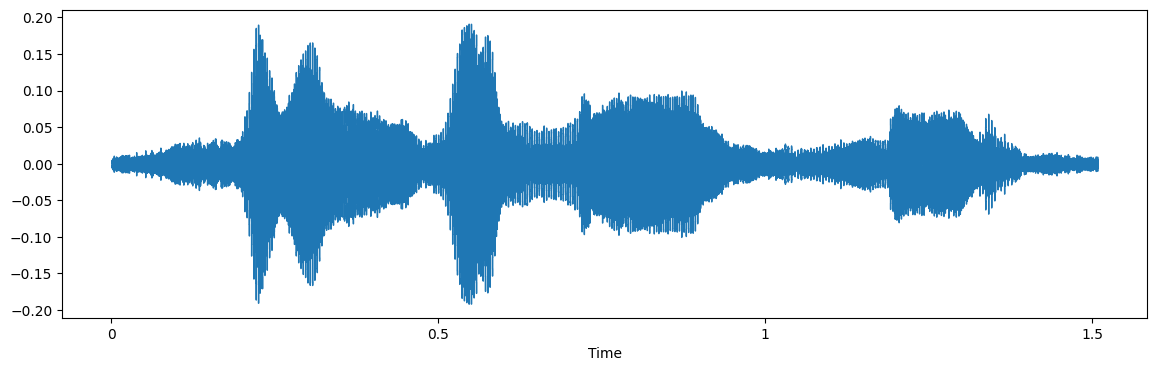

In [14]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

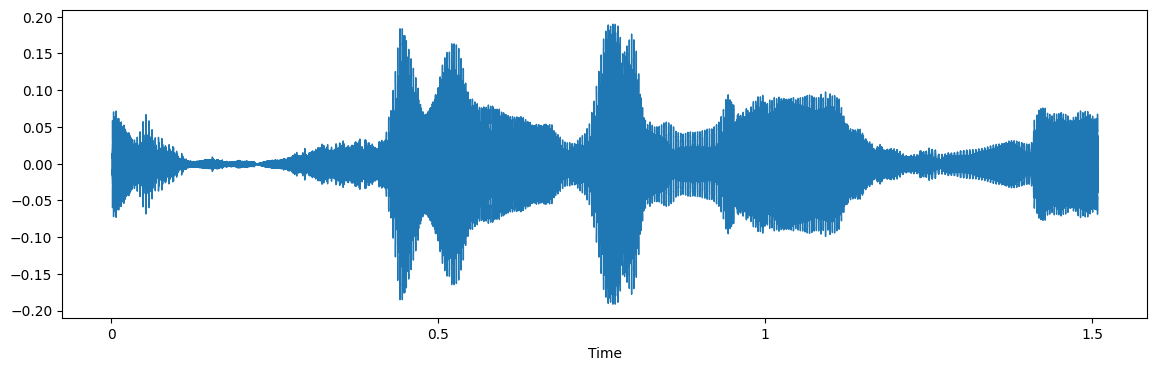

In [15]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [16]:
def extract_features(data):
    # ZCR - The rate of sign-changes of the signal during the duration of a particular frame
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft -STFT represents information about the classification of pitch and signal structure
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC- Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
   
    return result

In [17]:
X, Y = [], []
for path, emotion in zip(audio_df.Path, audio_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [18]:
len(X), len(Y), audio_df.Path.shape

(5600, 5600, (2800,))

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.054342,0.538993,0.596808,0.396304,0.364695,0.441099,0.413557,0.373404,0.568096,0.573010,...,0.000105,0.000157,0.000185,0.000133,0.000134,0.000070,0.000038,0.000034,6.250596e-06,negative
1,0.110137,0.697083,0.584487,0.454834,0.498180,0.560607,0.419765,0.505692,0.683622,0.545743,...,0.000210,0.000268,0.000288,0.000259,0.000250,0.000183,0.000140,0.000129,1.175540e-04,negative
2,0.058006,0.635519,0.406851,0.370775,0.404711,0.507197,0.455434,0.395454,0.421722,0.353537,...,0.000115,0.000082,0.000030,0.000011,0.000015,0.000021,0.000019,0.000015,9.260864e-07,negative
3,0.093872,0.666618,0.677987,0.471485,0.439530,0.477173,0.536676,0.433512,0.429865,0.455995,...,0.000142,0.000106,0.000055,0.000036,0.000039,0.000047,0.000043,0.000036,2.631793e-05,negative
4,0.113484,0.524840,0.684484,0.540808,0.336128,0.356515,0.429876,0.339963,0.316307,0.422898,...,0.000358,0.000351,0.000266,0.000088,0.000100,0.000195,0.000147,0.000067,2.281613e-06,negative


In [20]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

5 . Model Training and Evaluation

Data Splitting

In [21]:
from joblib import dump, load
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, Y, test_size = 0.20, random_state=42)
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)
dump(scaler, 'WebApp/scaler.joblib')
X_train_.shape, y_train_.shape, X_test_.shape, y_test_.shape

((4480, 162), (4480,), (1120, 162), (1120,))

SVM

 SVM Accuracy: 60.89285714285714 %
              precision    recall  f1-score   support

    negative       0.76      0.49      0.60       654
     neutral       0.96      0.96      0.96       142
    positive       0.40      0.69      0.51       324

    accuracy                           0.61      1120
   macro avg       0.71      0.71      0.69      1120
weighted avg       0.68      0.61      0.62      1120



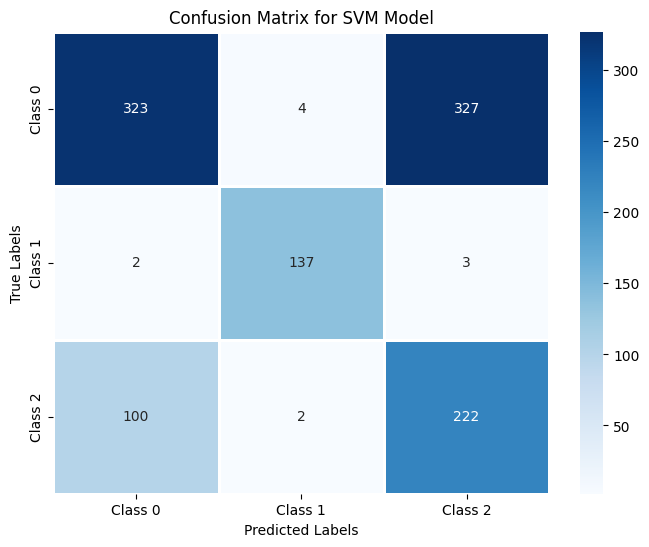

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

# Feature selection to reduce the feature set
selector = SelectKBest(f_classif, k=20)  # Use only top 20 features
X_train_reduced = selector.fit_transform(X_train_, y_train_)
X_test_reduced = selector.transform(X_test_)
# Adjusted SVM Model
svm_model = SVC(kernel='linear', C=0.3, max_iter=1000, random_state=42)
svm_model.fit(X_train_reduced, y_train_)
svm_preds = svm_model.predict(X_test_reduced)

# Evaluate SVM Model
svm_accuracy = accuracy_score(y_test_, svm_preds)
print(" SVM Accuracy:", svm_accuracy*100,"%")
print(classification_report(y_test_, svm_preds))
cm = confusion_matrix(y_test_, svm_preds)

# Convert confusion matrix into a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Class 0', 'Class 1', 'Class 2'], columns=['Class 0', 'Class 1', 'Class 2'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', linewidths=1, linecolor='white')
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



Random Forest

Random Forest Accuracy: 89.64285714285715 %
              precision    recall  f1-score   support

    negative       0.85      0.99      0.92       654
     neutral       1.00      0.99      0.99       142
    positive       0.98      0.66      0.79       324

    accuracy                           0.90      1120
   macro avg       0.94      0.88      0.90      1120
weighted avg       0.91      0.90      0.89      1120



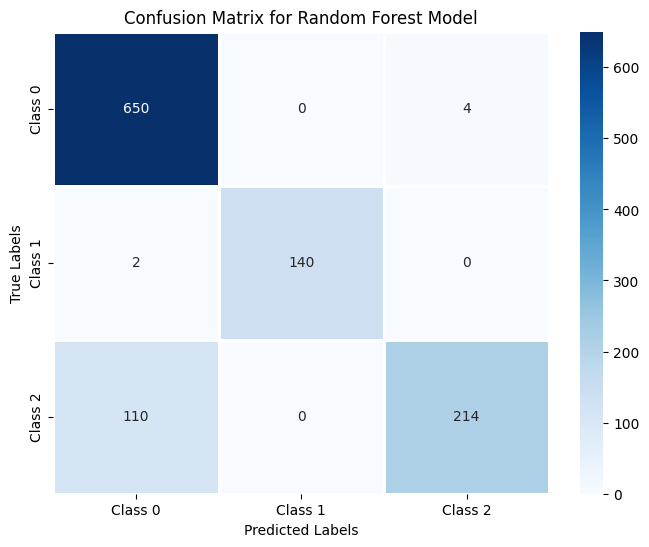

['D:/Project/FinalY/Webapp/emotion_model.joblib']

In [26]:
rf_model = RandomForestClassifier(n_estimators=30, max_depth=4, max_features='sqrt', min_samples_split=10, random_state=42)
rf_model.fit(X_train_, y_train_)
rf_preds = rf_model.predict(X_test_)
rf_accuracy = accuracy_score(y_test_, rf_preds)
print("Random Forest Accuracy:", rf_accuracy*100,"%")
print(classification_report(y_test_, rf_preds)) 
cm = confusion_matrix(y_test_, rf_preds)

# Convert confusion matrix into a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Class 0', 'Class 1', 'Class 2'], columns=['Class 0', 'Class 1', 'Class 2'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', linewidths=1, linecolor='white')
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
dump(rf_model, 'D:/Project/FinalY/Webapp/emotion_model.joblib')

In [24]:
import joblib
joblib.dump(rf_model, "emotion_model.pkl")


['emotion_model.pkl']

CNN

Class Mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Epoch 1/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3959 - loss: 1.3207 - val_accuracy: 0.5911 - val_loss: 0.9761 - learning_rate: 1.0000e-04
Epoch 2/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4542 - loss: 1.1543 - val_accuracy: 0.6009 - val_loss: 0.9596 - learning_rate: 1.0000e-04
Epoch 3/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5083 - loss: 1.0728 - val_accuracy: 0.6036 - val_loss: 0.9474 - learning_rate: 1.0000e-04
Epoch 4/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5107 - loss: 1.0442 - val_accuracy: 0.6107 - val_loss: 0.9411 - learning_rate: 1.0000e-04
Epoch 5/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5214 - loss: 0.9997 - val_accuracy: 0.6116 - val_loss: 0.9261 - learning_rate: 1.0000e-04
Epoch 6/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5474 - loss: 0.9930 - val_accuracy: 0.6179 - val_loss: 0.9168 - 

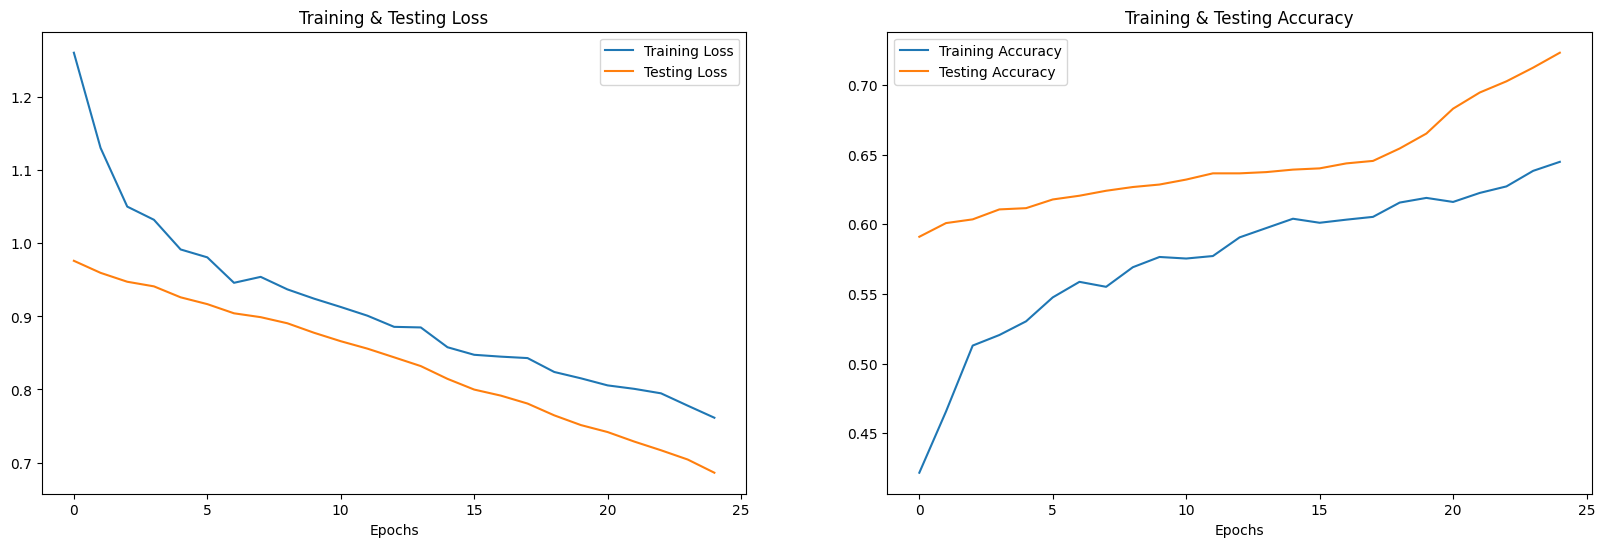

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


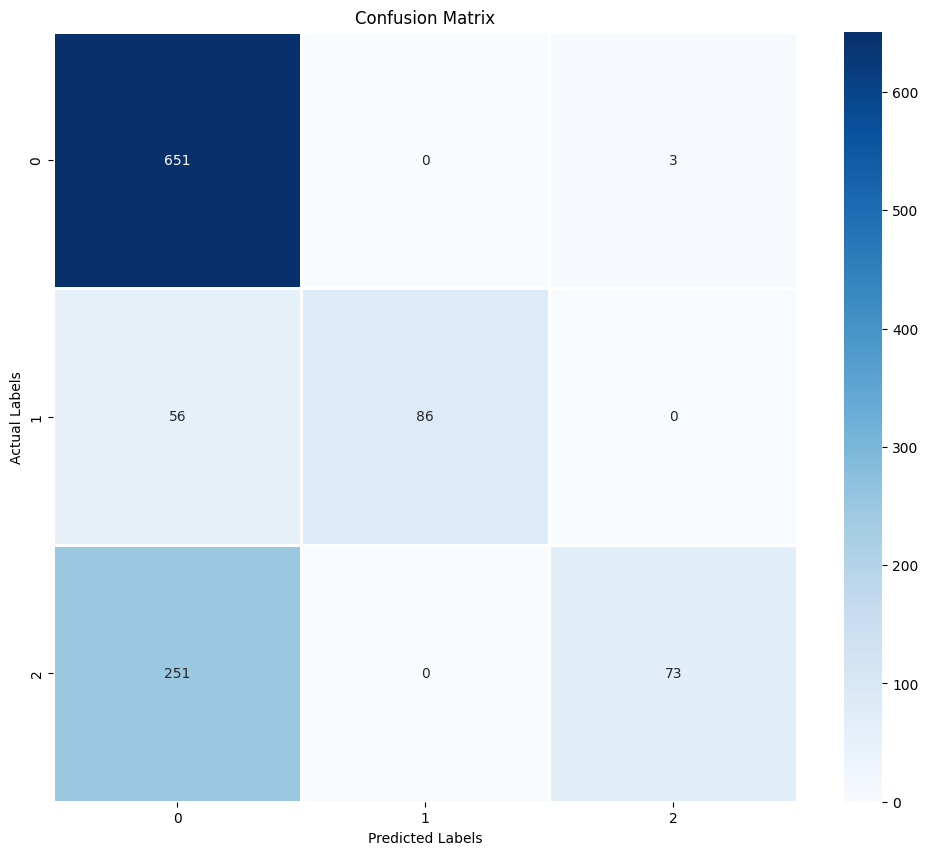

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       654
           1       1.00      0.61      0.75       142
           2       0.96      0.23      0.36       324

    accuracy                           0.72      1120
   macro avg       0.88      0.61      0.64      1120
weighted avg       0.80      0.72      0.67      1120



In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

# Define callbacks (if not already defined)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# ============================
# 1. Define and Train the Model
# ============================

# Simpler CNN model
model = Sequential([
    Conv1D(8, kernel_size=3, activation='relu', input_shape=(X_train_.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.6),
    Conv1D(16, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.6),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_)  # e.g., ['negative', 'neutral'] -> [0, 1]
y_test_encoded = label_encoder.transform(y_test_)

# Print mapping for reference
print("Class Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Convert to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded, num_classes=3)
y_test_onehot = to_categorical(y_test_encoded, num_classes=3)

# ============================
# 3. Plot Training & Testing Curves
# ============================
history = model.fit(
    X_train_, 
    y_train_onehot, 
    batch_size=32, 
    epochs=25, 
    validation_data=(X_test_, y_test_onehot),
    callbacks=[rlrp, early_stop]
)

# Evaluate the model
print("Accuracy of our model on test data:", model.evaluate(X_test_, y_test_onehot)[1] * 100, "%")
# Get the number of epochs actually trained
num_epochs = len(history.history['accuracy'])

# Plotting the training and testing loss/accuracy curves
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Plot Training and Testing Loss
ax[0].plot(range(num_epochs), train_loss, label='Training Loss')
ax[0].plot(range(num_epochs), test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Plot Training and Testing Accuracy
ax[1].plot(range(num_epochs), train_acc, label='Training Accuracy')
ax[1].plot(range(num_epochs), test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

# ============================
# 4. Confusion Matrix & Report
# ============================

# Convert y_test_ from one-hot encoding to class indices
y_test_class_indices = np.argmax(y_test_onehot, axis=1)

# Predict test data
pred_test = model.predict(X_test_)
y_pred = np.argmax(pred_test, axis=1)

# Confusion matrix and classification report
cm = confusion_matrix(y_test_class_indices, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=[0, 1, 2], columns=[0, 1, 2])
sns.heatmap(cm_df, annot=True, cmap='Blues', linewidths=1, linecolor='white', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Print the classification report
print(classification_report(y_test_class_indices, y_pred))
